In [116]:
# Librerias para leer, explorar y visualizar los datos
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
#nltk.download("stopwords")
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# libreria para el train test split
from sklearn.model_selection import train_test_split
# librerias de deep learning para pre-procesamiento de texto
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
# Modelado 
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

In [117]:
df_GPT = pd.read_csv('./datos/ensayos_GPT.csv')
df_humanos = pd.read_csv('./datos/ensayos_humanos.csv')

In [118]:
df_GPT['length'] = df_GPT['Ensayo'].str.len()
df_GPT

,Ensayo,length
0,La inteligencia artificial (IA) es la capacida...,3092
1,El cambio climático es la alteración del clima...,5429
2,La educación a distancia es una modalidad de e...,4925
3,La violencia de género es toda forma de violen...,10650
4,El veganismo es una filosofía y un estilo de v...,3282
...,...,...
94,El narcotráfico es un problema global que ha a...,5604
95,El cáncer es una enfermedad que se caracteriza...,4733
96,Las mascotas son una parte integral de la vida...,5869
97,"La educación en casa, también conocida como ed...",5347


In [119]:
df_humanos['length'] = df_humanos['Ensayo'].str.len()
df_humanos

,Ensayo,length
0,"Conciencia ecológica, un factor clave para el ...",4454
1,La huella silenciosa de las redes sociales en ...,6530
2,Sobre la importancia de erradicar el bullying ...,4398
3,El Principito Le Petit Prince de Antoine Saint...,8018
4,Apuntes para una historia de los derechos huma...,6072
...,...,...
93,La música rock y su impacto cultural El rock s...,2639
94,"Globalización, lenguaje y poesía1 G lobalizaci...",15394
95,Lectores perversos Dicen que San Francisco de ...,9795
96,Las consecuencias del narcotráfico y las medid...,2923


In [120]:
df_GPT.describe()

,length
count,99.000000
mean,5148.252525
std,1146.775118
min,2626.000000
25%,4706.500000
50%,5116.000000
75%,5698.000000
max,10650.000000


In [121]:
df_humanos.describe()

,length
count,98.000000
mean,7406.071429
std,5875.807693
min,1683.000000
25%,2921.500000
50%,5286.000000
75%,9176.000000
max,27227.000000


In [122]:
df_GPT['etiqueta'] = 'GPT'
df_humanos['etiqueta'] = 'humano'

In [123]:
df_GPT.head()

,Ensayo,length,etiqueta
0,La inteligencia artificial (IA) es la capacida...,3092,GPT
1,El cambio climático es la alteración del clima...,5429,GPT
2,La educación a distancia es una modalidad de e...,4925,GPT
3,La violencia de género es toda forma de violen...,10650,GPT
4,El veganismo es una filosofía y un estilo de v...,3282,GPT


In [124]:
# Creamos lista de numpy para visualizar usando wordcloud
GPT_text = " ".join(df_GPT.Ensayo.to_numpy().tolist())
humanos_text = " ".join(df_humanos.Ensayo.to_numpy().tolist())

In [125]:
# Estableciendo las stopwords del español
stopwords = set(stopwords.words('spanish'))

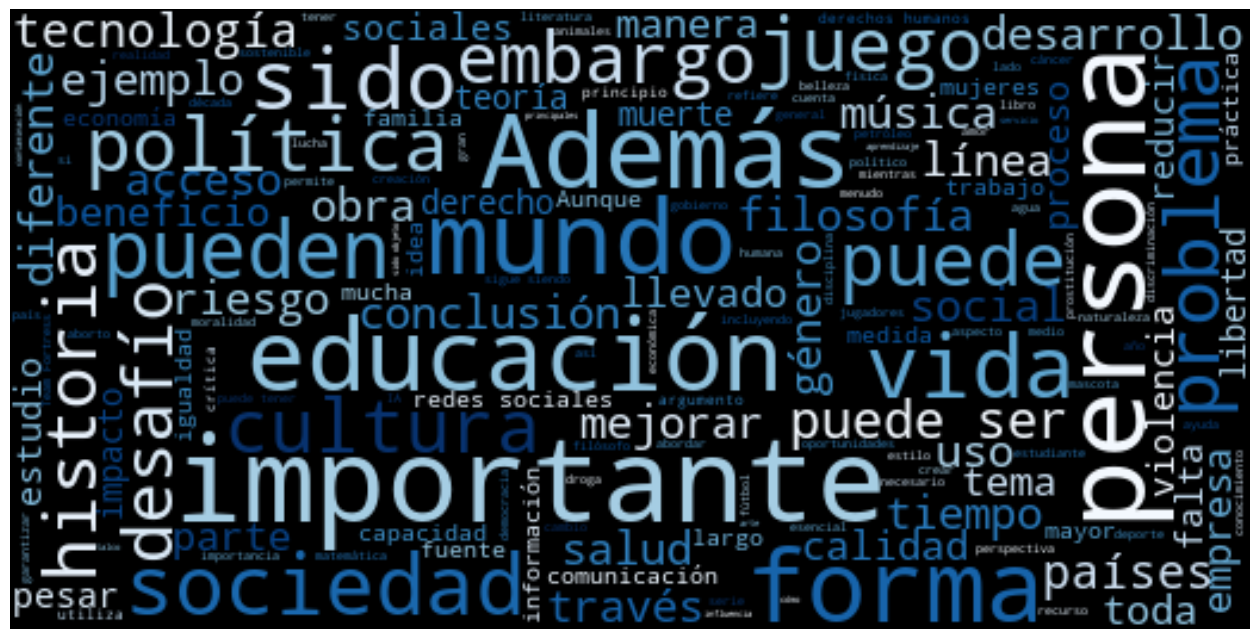

In [126]:
# wordcloud de ensayos GPT
GPT_cloud = WordCloud(width =520, height =260, stopwords=stopwords,max_font_size=50, background_color ="black", colormap='Blues').generate(GPT_text)
plt.figure(figsize=(16,10))
plt.imshow(GPT_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

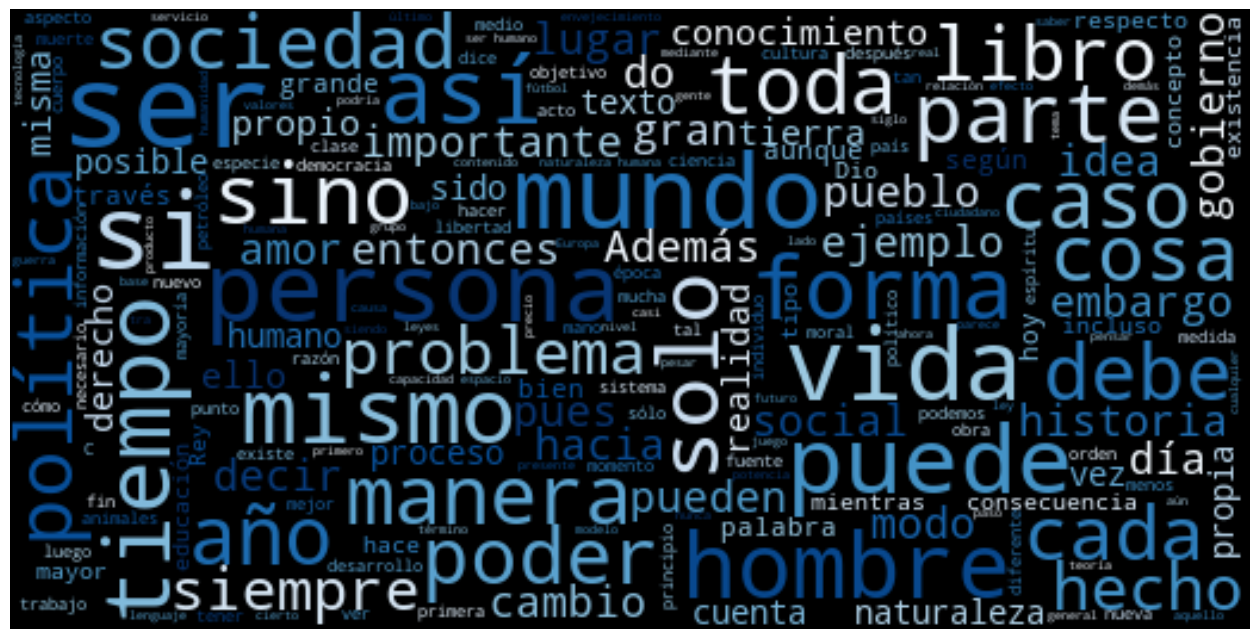

In [127]:
# wordcloud de ensayos humanos
humanos_cloud = WordCloud(width =520, height =260, stopwords=stopwords,max_font_size=50, background_color ="black", colormap='Blues').generate(humanos_text)
plt.figure(figsize=(16,10))
plt.imshow(humanos_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

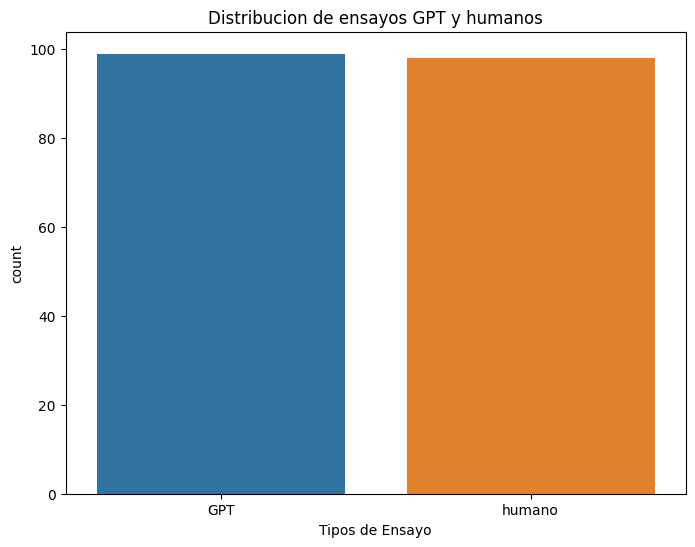

In [128]:
# Visualizando la cantidad de ensayos de cada categoria
ensayos_df = pd.concat([df_GPT, df_humanos]).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(data=ensayos_df, x=ensayos_df['etiqueta'])
plt.title('Distribucion de ensayos GPT y humanos')
plt.xlabel('Tipos de Ensayo')
plt.show()

In [129]:
# Mapeando el ensayo a un numero, 0 para GPT y 1 para humano
ensayos_df['tipo_ensayo']= ensayos_df['etiqueta'].map({'GPT': 0, 'humano': 1})
ensayos_df = ensayos_df.sample(frac=1)
etiqueta_ensayo = ensayos_df['tipo_ensayo'].values
# Split data into train and test
train_ensayos, test_ensayos, train_etiquetas, test_etiquetas = train_test_split(ensayos_df['Ensayo'], etiqueta_ensayo, test_size=0.3, random_state=434)

In [130]:
# Definimos los hiperparametros del pre-procesamiento
max_len = 1000
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500

In [131]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token=oov_tok)
tokenizer.fit_on_texts(train_ensayos)

In [132]:
#Obtenemos los índices de las palabras
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'de': 2,
 'la': 3,
 'y': 4,
 'en': 5,
 'que': 6,
 'el': 7,
 'a': 8,
 'los': 9,
 'se': 10,
 'las': 11,
 'es': 12,
 'una': 13,
 'un': 14,
 'del': 15,
 'para': 16,
 'por': 17,
 'su': 18,
 'como': 19,
 'no': 20,
 'con': 21,
 'o': 22,
 'lo': 23,
 'más': 24,
 'ha': 25,
 'al': 26,
 'puede': 27,
 'también': 28,
 'sus': 29,
 'ser': 30,
 'son': 31,
 'mundo': 32,
 'vida': 33,
 'sin': 34,
 'han': 35,
 'este': 36,
 'pero': 37,
 'todo': 38,
 'personas': 39,
 'importante': 40,
 'pueden': 41,
 'forma': 42,
 'entre': 43,
 'sido': 44,
 'además': 45,
 'sobre': 46,
 'desde': 47,
 'si': 48,
 'esto': 49,
 'ya': 50,
 'fue': 51,
 'tiene': 52,
 'uno': 53,
 'sociedad': 54,
 'esta': 55,
 'educación': 56,
 'muchos': 57,
 'otros': 58,
 'política': 59,
 'parte': 60,
 'otro': 61,
 'sociales': 62,
 'tener': 63,
 'manera': 64,
 'tiempo': 65,
 'nos': 66,
 'humana': 67,
 'todos': 68,
 'algunos': 69,
 'debe': 70,
 'embargo': 71,
 'cada': 72,
 'social': 73,
 'gran': 74,
 'así': 75,
 'estos': 76,
 'cultura': 

In [133]:
# Contando palabras unicas
print('Hay', len(word_index), 'palabras unicas.')

Hay 15185 palabras unicas.


In [134]:
#Hacemos la secuenciación y el padding en los datos de entrenamiento y prueba
training_sequences = tokenizer.texts_to_sequences(train_ensayos)
training_padded = pad_sequences(training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test_ensayos)
testing_padded = pad_sequences(testing_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)


In [135]:
print(type(train_ensayos))
print(train_ensayos)

<class 'pandas.core.series.Series'>
94     El narcotráfico es un problema global que ha a...
22     El ser humano siempre se ha planteado la cuest...
135    La moral es algo que todas las personas en el ...
124    La naturaleza ¿A qué nos referimos exactamente...
180    Los efectos positivos de la actividad física e...
                             ...                        
175    Analizando la pasión por el fútbol en el país ...
196    ¿ Cómo deben ser tratados los pacientes con cá...
112    El maltrato animal en la sociedad industrial c...
170    Democracia y Derecho al voto en la Antigua Gre...
97     La educación en casa, también conocida como ed...
Name: Ensayo, Length: 137, dtype: object


In [136]:
#Averiguamos la forma de los tensores
print('Tensores de entrenamiento:', training_padded.shape)
print('Tensores de prueba:', testing_padded.shape)

Tensores de entrenamiento: (137, 1000)
Tensores de prueba: (60, 1000)


In [137]:
#Antes del padding
print('Antes del padding:', (len(training_sequences[0]), len(training_sequences[1])) )

#Después del padding
print('Después del padding:', (len(training_padded[0]), len(training_padded[1])) )

Antes del padding: (890, 735)
Después del padding: (1000, 1000)


In [138]:
# Definimos los hiperparametros del modelo

vocab_size = 500
embeding_dim = 16
drop_value = 0.2
n_dense = 24

In [139]:
#Arquitectura densa del modelo
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))
# Compilando el modelo
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# ajustando el modelo a los datos
num_epochs = 100
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model.fit(training_padded, train_etiquetas, epochs=num_epochs, validation_data=(testing_padded, test_etiquetas), callbacks =[early_stop], verbose=2)

Epoch 1/100
5/5 - 1s - loss: 0.6931 - accuracy: 0.5036 - val_loss: 0.6923 - val_accuracy: 0.6167 - 535ms/epoch - 107ms/step
Epoch 2/100
5/5 - 0s - loss: 0.6920 - accuracy: 0.5693 - val_loss: 0.6916 - val_accuracy: 0.5167 - 28ms/epoch - 6ms/step
Epoch 3/100
5/5 - 0s - loss: 0.6917 - accuracy: 0.5620 - val_loss: 0.6911 - val_accuracy: 0.5167 - 28ms/epoch - 6ms/step
Epoch 4/100
5/5 - 0s - loss: 0.6906 - accuracy: 0.5766 - val_loss: 0.6906 - val_accuracy: 0.5167 - 28ms/epoch - 6ms/step
Epoch 5/100
5/5 - 0s - loss: 0.6901 - accuracy: 0.6569 - val_loss: 0.6900 - val_accuracy: 0.7667 - 29ms/epoch - 6ms/step
Epoch 6/100
5/5 - 0s - loss: 0.6891 - accuracy: 0.7153 - val_loss: 0.6893 - val_accuracy: 0.9333 - 28ms/epoch - 6ms/step
Epoch 7/100
5/5 - 0s - loss: 0.6878 - accuracy: 0.8175 - val_loss: 0.6884 - val_accuracy: 0.8333 - 29ms/epoch - 6ms/step
Epoch 8/100
5/5 - 0s - loss: 0.6871 - accuracy: 0.8321 - val_loss: 0.6876 - val_accuracy: 0.8833 - 30ms/epoch - 6ms/step
Epoch 9/100
5/5 - 0s - loss: 

In [140]:
testTexts = ["El miedo como recurso en el cine y su evolución El miedo es una de las emociones más explotadas en el cine. A pesar de tratarse de una sensación desagradable, muchas personas la encuentran sumamente adictiva. Esto se debe a su increíble capacidad para desligarnos de la rutina, pero al mismo tiempo, su potencial para producir una expectativa irracional hacia peligros o amenazas que no son reales. Tomando todo esto en consideración, resulta muy interesante analizar su evolución a través de la historia. La primera emoción que sintieron las personas al ver una película fue el miedo. Esto quedó registrado en el año 1896, cuando los hermanos Lumière anunciaron el estreno de la cinta que tenía como nombre “Llegada del tren a la estación de La Ciotat”, que es considerada la primera pieza cinematográfica. Al tratarse de una novedad, no tardó en atraer la atención del público francés, que no estaba acostumbrado a ver una pantalla con imágenes en movimiento. Sin embargo, su reacción ante la aparición del tren que se acercaba a ellos fueron una serie gritos y sobresaltos. Nadie, en ese entonces, estaba preparado para ver cómo un vehículo de grandes proporciones se aproximaba a ellos, dando la sensación de que iban a ser atropellados. Muchos sintieron un miedo sin precedentes y salieron despavoridos. De este modo, y de una manera casual, se estableció una de las reglas más importantes del cine de terror. Me refiero al hecho de que los espectadores deben sentirse amenazados, permitiendo que sientan miedo y experimenten otras sensaciones afines. No obstante, recién en el año 1910 apareció la primera película que tenía como objetivo principal asustar al público. Se trataba de una producción en blanco y negro que contaba la historia del monstruo creado por el doctor Frankenstein, una de los personajes más emblemáticos de la literatura gótica. El encargado de dirigir este film fue el estadounidense J. Searle Dawley, que logró crear un ambiente tétrico a pesar de las limitaciones tecnológicas del momento. Los primeros planos de la criatura, el uso de claroscuros y una banda sonora adecuada, fueron suficientes para que los espectadores se adentraran en un mundo de espanto. Esto fue esencial para sentar las bases del género de terror, que luego sería consolidado por un grupo de cineastas alemanes que se encargaron de incorporar características propias del expresionismo de su país. La película más representativa de esta escuela es “Nosferatu” de 1922, que está inspirada en el personaje de Drácula creado por Bram Stoker. Casi medio siglo después, Alfred Hitchcock revolucionó por completo el género. Atrás quedaron las criaturas malévolas y las amenazas visibles, en cambio, para que los espectadores se sintieran atemorizados se empezó a utilizar el suspenso. De esta forma, las personas podían explorar sus propios miedos, un recurso que antes solo era utilizado en la literatura. Actualmente, las películas de cine buscan provocar miedo mezclando el suspenso y la presencia de seres sobrenaturales. También existe una fuerte demanda por elementos más impactantes, pero no cabe duda que lo más efectivo sigue siendo lo clásico, pues nada se compara con sentir un terror personalizado que solo nosotros podemos entender.", 
             "El transporte público es un servicio esencial en la mayoría de las ciudades del mundo. Se trata de una red de transporte de pasajeros que abarca diferentes medios, como autobuses, trenes, tranvías, metro y taxis, entre otros. El transporte público es una necesidad para muchas personas, ya sea para ir a trabajar, a la escuela o para realizar actividades diarias. El transporte público ofrece muchas ventajas para la sociedad. En primer lugar, es una forma sostenible de transporte que reduce la cantidad de vehículos en la carretera, lo que disminuye la contaminación y mejora la calidad del aire. También ayuda a reducir la congestión del tráfico y el tiempo de viaje, lo que a su vez reduce el estrés en los usuarios. Además, el transporte público es una forma económica de viajar. A menudo, los precios son más bajos en comparación con los costos de poseer y mantener un vehículo personal. Esto puede ser especialmente beneficioso para personas con bajos ingresos que necesitan transporte diario. Otro beneficio del transporte público es que promueve la inclusión social y la igualdad de acceso. El transporte público puede conectar a personas de diferentes áreas, facilitando la movilidad de aquellos que no tienen un vehículo propio. Esto es particularmente importante en áreas rurales o en zonas urbanas donde el acceso al transporte puede ser limitado. Sin embargo, el transporte público también presenta algunos desafíos y limitaciones. Uno de los mayores desafíos es la falta de financiación y la falta de mantenimiento y actualización adecuados. Esto puede llevar a problemas como la falta de seguridad, la falta de comodidad y el envejecimiento de los vehículos y las infraestructuras. Además, el transporte público puede ser limitado en términos de rutas y horarios. Esto puede ser especialmente difícil para personas que necesitan viajar a lugares específicos fuera de las rutas de transporte público. Además, los horarios limitados pueden dificultar la flexibilidad para las personas que necesitan realizar actividades diarias fuera del horario laboral. También hay preocupaciones de seguridad al utilizar el transporte público. El crimen puede ser un problema en algunas áreas, lo que puede disuadir a algunas personas de utilizar el transporte público. Además, la posibilidad de accidentes o averías mecánicas también puede ser una preocupación. A pesar de estos desafíos, el transporte público sigue siendo un servicio vital para muchas personas. Para mejorar el transporte público, se necesitan inversiones en financiamiento y actualizaciones de infraestructura, así como esfuerzos para aumentar la seguridad y la comodidad. Además, se deben desarrollar nuevas tecnologías para mejorar la eficiencia y la accesibilidad. En resumen, el transporte público es un servicio esencial para la sociedad, que ofrece muchos beneficios como la sostenibilidad, la economía y la inclusión social. A pesar de los desafíos y limitaciones, el transporte público sigue siendo una necesidad para muchas personas. Por lo tanto, es importante seguir trabajando en mejoras para garantizar que este servicio vital siga siendo una opción viable y efectiva para el transporte de pasajeros."
             ]

In [141]:
testText_sequence = tokenizer.texts_to_sequences(testTexts)
#print(testText_sequence)
testText_padded = pad_sequences(testText_sequence, maxlen=max_len, padding=padding_type, truncating=trunc_type)
labels = model.predict(testText_padded)

1/1 [==============================] - 0s 37ms/step


In [142]:
print(labels)

[[0.97452766]
 [0.2945945 ]]


In [143]:
import pickle
file = open("WebApp/modelo/modelo_GPT_Detective.pkl", "wb")

pickle.dump(model, file)

file = open("WebApp/modelo/Tokenizer.pkl", "wb")

pickle.dump(tokenizer, file)